# Titanic Challenge
## I Introduction

----------
### 1.Features Analysis
Here is the reference from Chris Deotte.

https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818 

In his simple model using R language, he scores 82% only using Names. He found that the male except boy is dead and the female except surname family dead are survived. This is a decision tree model which is simple and effective. So according to this logical method, other methods based on the trees should be tried. But before that, we will try to analyse the features and data cleaning. Then we create the feature mentioned by Chris Deotte and modify the test features accordingly.

### 2.Supervised methods
Here is the reference from Chris Deotte.

https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688

In his notebook, he scored 0.85167. The notebook has tried XGBoost with the previous features and other new added features. It seems that some features should be dropped since it is a kind of noise. So in my notebook, the random forest and XGBoost will be chosen. These two methods are better than other methods because they are based on the Cart tree model, which is a good chioce for this dataset.


## II Feature Analysis and Process

### 1.Load data

In [1]:
import numpy as np
import pandas as pd

# Load train data as train_data
in_file = '/kaggle/input/titanic/train.csv'
train_data = pd.read_csv(in_file)
print("There are {} samples in train_data".format(len(train_data)))

# Load test data as test_data
in_file = '/kaggle/input/titanic/test.csv'
test_data = pd.read_csv(in_file)
print('There are {} samples in test_data'.format(len(test_data)))
PassengerId=test_data['PassengerId']

# Set the labels of test_data as na
test_data['Survived'] = np.nan

# Concat the features of train dataset and test dataset
all_data = pd.concat([train_data, test_data], ignore_index=True)

# Show the whole dataset informations
all_data.info()
display(all_data.head())

There are 891 samples in train_data
There are 418 samples in test_data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Check how many null values in each feature.
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

**For the null values above, we dicide to deal as following.**
- The age null values can be filled by the regression method.
- The 'Embarked' features can be filled according to the fare and pclass.
- There are many null values in 'Cabin' features. For the better predictions, it is believed to delete the feature of 'Cabin'. But here we need this feature because when the ship sinks, certain parts of the ship have different probability drown in water. So we deal to make a new feature to substitute the feature.
- The fare can be filled up with median value or mean value. 
- The survived is the target to predict.

### 2.Missing values process

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

#### 2.1 Embarked
For the correctness, do not fill the null values only by the original feature values. We need to see other features too. So we can see about the passangers relatives number, the pclass, the fare, and the ticket.

In [4]:
# Show the samples with embarked null
display(all_data[all_data['Embarked'].isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [5]:
#  Only reserve the numbers of the tickets.  &(all_data['Pclass']==1)
#  We assume that the ticket number is probably same if it is bought from the same place
all_data['Ticket_num'] = all_data['Ticket'].map(lambda x: re.sub("\D", "", x))
all_data['Ticket_num'] = pd.to_numeric(all_data['Ticket_num'])
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,521171.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,17599.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,23101282.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,113803.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,373450.0


In [6]:
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Ticket_num        4
dtype: int64

In [7]:
#  Select the passangers relatives number equal to 0, and the pclass equal to 1, the ticket number between 113000 and 114000
select_data = all_data[(all_data['Parch']==0)&(all_data['SibSp']==0)\
                       &(all_data['Ticket_num']<114000)&(all_data['Ticket_num']>110000)]
select_data.sort_values('Ticket_num').head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_num
759,760,1.0,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,110152.0
257,258,1.0,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B77,S,110152.0
504,505,1.0,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B79,S,110152.0
475,476,0.0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0,A14,S,110465.0
110,111,0.0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0,C110,S,110465.0


In [8]:
select_data.Embarked.value_counts()

S    54
C    10
Name: Embarked, dtype: int64

**The embarked place is obviously connected with the fare and the tickets. From the value counts, the probability of S is more possible than other two options.**

In [9]:
all_data['Embarked'] = all_data['Embarked'].fillna('S') 

#### 2.2 Age

The age feature has 263 null values. So we use random forest regression model to simulate the value. The features we use here are sex, title, pclass.


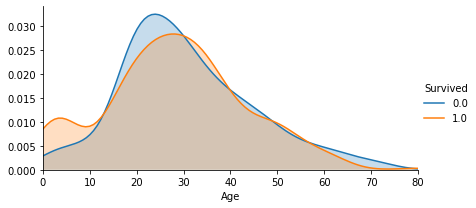

In [10]:
facet = sns.FacetGrid(all_data[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, all_data.loc[0:890,'Age'].max()))
facet.add_legend()

In [11]:
from sklearn.ensemble import RandomForestRegressor

age_df = all_data[['Age', 'Pclass','Sex','Parch','SibSp']]
age_df=pd.get_dummies(age_df)
known_age = age_df[age_df.Age.notnull()].to_numpy()
unknown_age = age_df[age_df.Age.isnull()].to_numpy()
y = known_age[:, 0]
X = known_age[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedAges = rfr.predict(unknown_age[:, 1::])
all_data.loc[(all_data.Age.isnull()), 'Age'] = predictedAges 

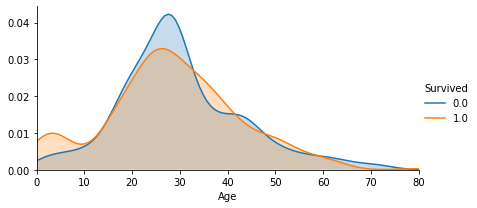

In [12]:
facet = sns.FacetGrid(all_data[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, all_data.loc[0:890,'Age'].max()))
facet.add_legend()

#### 2.3 Fare

The fare feature has 1 null values. So we use median value to fill up.

In [13]:
fare=all_data.loc[(all_data['Embarked'] == "S") & (all_data['Pclass'] == 3), 'Fare'].median()
all_data['Fare']=all_data['Fare'].fillna(fare)

### 3. Create new features

We all know the movie story of tatanic that women and children escapes first and their survival rate shall be higher than other category. It is a easy way to believe all women and children survived and all man died. But it is contracted with boys. So we gona to extract the titles as man, woman and boy.


#### 3.1 Title

In [14]:
# Extract the titles from name feature

# Create a set for all unique titles
titles = set()

# Extract from the name feature
for name in all_data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())
print(titles)

{'Major', 'Mrs', 'Sir', 'Jonkheer', 'Col', 'Miss', 'Rev', 'Lady', 'Don', 'Master', 'the Countess', 'Dona', 'Mme', 'Mlle', 'Dr', 'Mr', 'Capt', 'Ms'}


In [15]:
# Make a dictionary for mapping the titles into three kinds
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Master",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona" : "Royalty"    
}

def get_titles(data):
    data['Title'] = data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    data['Title'] = data['Title'].map(Title_Dictionary)
    return data

get_titles(all_data)
all_data['Title'].value_counts()  

Mr         757
Miss       262
Mrs        200
Master      62
Officer     23
Royalty      5
Name: Title, dtype: int64

#### 3.2 Surname

We could make the exception list of male and female. Then change the features of test surname in the list into the dead features or survived features according to the list.

{'Elias', 'Bourke', 'Lefebre', 'Cacic', 'Goodwin', 'Rice', 'Barbara', 'Skoog', 'Panula', 'Oreskovic', 'Attalah', 'Sage', 'Turpin', 'Ford', 'Strom', 'Jussila', 'Canavan', 'Lobb', 'Vander Planke', 'Caram', 'Rosblom', 'Boulos', 'Van Impe', 'Lahtinen', 'Robins', 'Arnold-Franchi', 'Danbom', 'Ilmakangas', 'Olsson', 'Johnston', 'Zabour', 'Palsson'}
{'Nakid', 'Cardeza', 'Beane', 'Frolicher-Stehli', 'McCoy', 'Goldenberg', 'Greenfield', 'Beckwith', 'Jonsson', 'Taylor', 'Harder', 'Jussila', 'Duff Gordon', 'Bradley', 'Bishop', 'Frauenthal', 'Daly', 'Kimball', 'Chambers', 'Dick', 'Moubarek'}


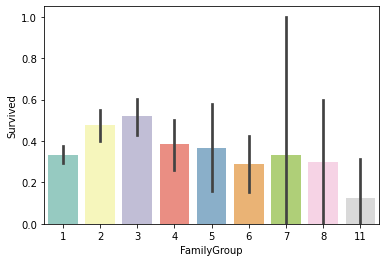

In [16]:
# Extract from name feature
all_data['Surname'] = all_data['Name'].map(lambda name:name.split(',')[0].strip())

# Create a new feature as surname frequency
all_data['FamilyGroup'] = all_data['Surname'].map(all_data['Surname'].value_counts()) 

sns.barplot(x='FamilyGroup', y='Survived', data=all_data, palette='Set3')

Female_Child_Group=all_data.loc[(all_data['FamilyGroup']>=2) & ((all_data['Age']<=16) | (all_data['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
Dead_List=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
print(Dead_List)

Male_Adult_Group=all_data.loc[(all_data['FamilyGroup']>=2) & (all_data['Age']>16) & (all_data['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
Survived_List=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)
print(Survived_List)


In [17]:
all_data.loc[(all_data['Survived'].isnull()) & (all_data['Surname'].apply(lambda x:x in Dead_List)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
all_data.loc[(all_data['Survived'].isnull()) & (all_data['Surname'].apply(lambda x:x in Survived_List)),\
             ['Sex','Age','Title']] = ['female',5.0,'Miss']

#### 3.3 FamilySize

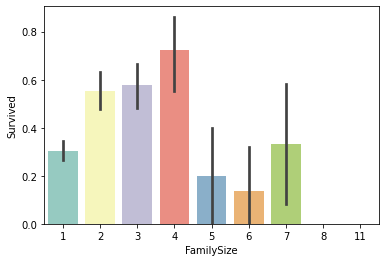

In [18]:
all_data['FamilySize']=all_data['SibSp']+all_data['Parch']+1
sns.barplot(x="FamilySize", y="Survived", data=all_data, palette='Set3')

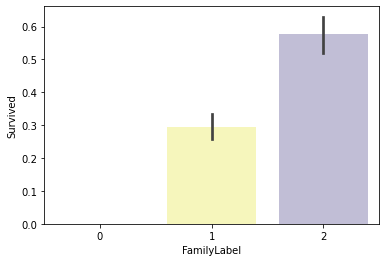

In [19]:
def Fam_label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 7)) | (s == 1):
        return 1
    elif (s > 7):
        return 0
all_data['FamilyLabel']=all_data['FamilySize'].apply(Fam_label)
sns.barplot(x="FamilyLabel", y="Survived", data=all_data, palette='Set3')

#### 3.4 Deck

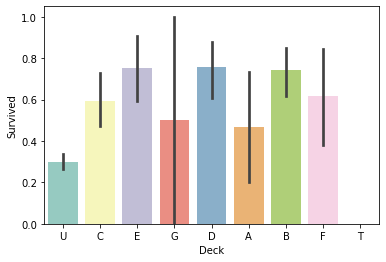

In [20]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck']=all_data['Cabin'].str.get(0)
sns.barplot(x="Deck", y="Survived", data=all_data, palette='Set3')

#### 3.5 TicketGroup

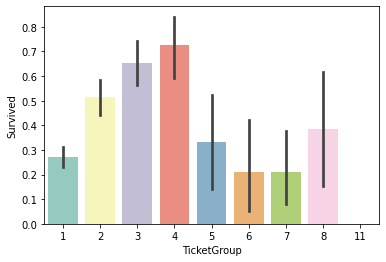

In [21]:
Ticket_Count = dict(all_data['Ticket'].value_counts())

all_data['TicketGroup'] = all_data['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

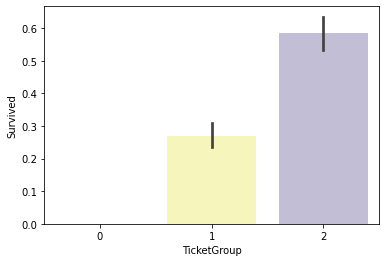

In [22]:
def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

all_data['TicketGroup'] = all_data['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup', y='Survived', data=all_data, palette='Set3')

In [23]:
all_data = all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data.isnull().sum()

Survived       418
Pclass           0
Sex              0
Age              0
Fare             0
Embarked         0
Title            0
FamilyLabel      0
Deck             0
TicketGroup      0
dtype: int64

### 4.Model Prediction

In [24]:
all_data = all_data[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','FamilyLabel','Deck','TicketGroup']]
all_data = pd.get_dummies(all_data)
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()].drop('Survived',axis=1)
X = train.to_numpy()[:,1:]
y = train.to_numpy()[:,0]

#### 4.1 Random Forest

In [25]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

select = SelectKBest(k = 20)
clf = RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')

pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

cv_result = cross_validate(pipeline, X, y, cv= 10)
print("CV Test Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_result['test_score']), \
                                                     np.std(cv_result['test_score'])))



/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [23] are constant.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


CV Test Score : Mean - 0.8395006 | Std - 0.04977098 


In [26]:
test_x = test.to_numpy()

In [27]:
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission_test_RF.csv", index=False)

#### 4.2 XGBoost

In [28]:
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

select = SelectKBest(k = 20)
clf = XGBClassifier(
                     max_depth=3, 
                     learning_rate=0.1, 
                     n_estimators=100, 
                     silent=True, 
                     objective='binary:logistic', 
                     booster='gbtree', 
                     nthread=None, 
                     gamma=0, 
                     subsample=0.8, 
                     colsample_bytree=1, 
                     colsample_bylevel=1, 
                     reg_alpha=0, 
                     reg_lambda=1, 
                     scale_pos_weight=1.2, 
                     base_score=0.5)

pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

cv_result = cross_validate(pipeline, X, y, cv= 10)

print(cv_result['test_score'])
print("CV Test Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_result['test_score']), \
                                                     np.std(cv_result['test_score'])))


[05:52:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:52:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:52:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


In [29]:
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("submission_test_XG.csv", index=False)

> ### 5 Conclusion

The random forest is better than XGBoost. So we submit the random forest result.